In [28]:
import os
import numpy as np
import pandas as pd
from configs import Config

tuhab_meta_csv_path = '/home/gayal/ssl-project/gpatchTST/tuhab_patient_metadata_ds.csv'
model_path = '/home/gayal/ssl-project/gpatchTST/saved_models/pretrain/tuhab_pretrain_tuab_fixed/TUH-83/2025-04-14_16-31-47'
# get the yaml
config_dilename = [file for file in os.listdir(model_path) if file.endswith('.yaml')].pop()
checkpoint_files = [file for file in os.listdir(model_path) if file.endswith('.pth')]

config_filepath = os.path.join(model_path, config_dilename)
config = Config(config_file=config_filepath).get()

checkpoint_paths = [os.path.join(model_path, path) for path in checkpoint_files]

print(config_filepath)

/home/gayal/ssl-project/gpatchTST/saved_models/pretrain/tuhab_pretrain_tuab_fixed/TUH-83/2025-04-14_16-31-47/test_pretrain_repo_tuhab.yaml


In [29]:
data_config = config['data']
model_config = config['model']

metadata_df = pd.read_csv(tuhab_meta_csv_path)
metadata_df.head()

,filename,patient_name,age,gender,split,label
0,aaaaaaaq_s004_t000,aaaaaaaq,26,F,train,abnormal
1,aaaaaaaq_s005_t001,aaaaaaaq,27,F,train,abnormal
2,aaaaaaat_s002_t001,aaaaaaat,49,M,train,abnormal
3,aaaaaaav_s004_t000,aaaaaaav,35,F,train,normal
4,aaaaaabn_s005_t000,aaaaaabn,24,F,train,normal


In [30]:
# loading model checkpoints
from get_models import get_patchTST_model
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def get_model_from_checkpoint(check_point_path, model_config, data_config, device):
    num_patches = (max(model_config['seq_len'], model_config['patch_length']) - model_config['patch_length']) // model_config['stride'] + 1
    train_num_mask_patches = int(model_config['mask_ratio']* num_patches)
    print(f"num_patches: {num_patches}, train_num_mask_patches: {train_num_mask_patches}")
    

    
    model = get_patchTST_model(num_variates=data_config['n_vars'],
                                forecast_length=data_config['pred_len'],
                                patch_len=model_config['patch_length'],
                                stride=model_config['stride'],
                                num_patch=num_patches,
                                n_layers=model_config['num_layers'],
                                d_model=model_config['d_model'],
                                n_heads=model_config['num_heads'],
                                shared_embedding=model_config['shared_embedding'],
                                d_ff=model_config['d_ff'],
                                norm=model_config['norm'],
                                attn_dropout=model_config['attn_dropout'],
                                dropout=model_config['dropout'],
                                activation=model_config['activation'],
                                res_attention=model_config['res_attention'],
                                pe=model_config['pe'],
                                learn_pe=model_config['learn_pe'],
                                head_dropout=model_config['head_dropout'],
                                head_type=model_config['head_type']
                            ).to(device)
    
    model.load_state_dict(torch.load(check_point_path)['model_state_dict'])#, weights_only=True))
    model.eval()
    return model


Using device: cuda


## ZSL

In [31]:
from data import TUAB_Dataset, get_tuab_dataloaders

_, _, test_tuab_dataset = get_tuab_dataloaders(
    root_path=data_config['root_path'],
    data_path=data_config['data_path'],
    csv_path=data_config['csv_path'],
    metadata_csv_path='tuhab_patient_metadata_ds.csv',
    batch_size=64,#data_config['batch_size'],
    num_workers=data_config['num_workers'],
    drop_last=False,
    size=[model_config['seq_len'], 
          model_config['target_dim'],
          model_config['patch_length']]
)

Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: train, Patients: 1450, Files: 1783
Total Sequences: 126073
Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: val, Patients: 207, Files: 258
Total Sequences: 18398
Found 2072 patients with 2569 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuhab_preprocessed/tuh_patient_splits.pkl
Split: test, Patients: 415, Files: 528
Total Sequences: 36970


In [32]:
# next(iter(test_tuab_dataset))
len(test_tuab_dataset.dataset), len(test_tuab_dataset), len(test_tuab_dataset.dataset.selected_files)

(36970, 578, 528)

In [33]:
val_mask_type = 'random'

mask_ratio = 0.3# model_config['mask_ratio']
masked_value = model_config['masked_value']
stride = model_config['stride']
independent_channel_masking = model_config['independent_channel_masking']
patch_len = model_config['patch_length']
forecasting_num_patches = model_config['forecasting_num_patches']
fixed_position = None

In [34]:
import torch
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from pretrain import (create_patches, 
apply_mask, plot_sample_reconstruction, 
create_mask, apply_inv_mask)

torch.set_grad_enabled(False)

def get_embeddings_for_model(test_tuab_dataset, model, patch_len, stride):
    all_embeddings = []
    all_labels = []
    all_ages = []
    all_genders = []
    all_filenames = []
    all_patient_names = []
    
    # test_tuab_step_pbar = tqdm(test_tuab_dataset, desc="Extracting data", total=len(test_tuab_dataset), leave=False)
    test_tuab_step_pbar = tqdm(test_tuab_dataset, desc="Extracting data", total=8, leave=False)
    
    for batch in test_tuab_step_pbar:
        data = batch['past_values'].to(device)  # [batch_size, seq_len, channels]
        labels = batch['label']  # [batch_size]
        ages = batch['age']      # [batch_size]
        genders = batch['gender'] # [batch_size]
        filenames = batch['filename']
        patient_names = batch['patient_name']
        
        input_patches, _ = create_patches(data, patch_len, stride)
        
        with torch.no_grad():
            embeddings = model.backbone(input_patches)
        
        embeddings_cpu = embeddings.detach().cpu().numpy()
        
        # Store all data
        all_embeddings.extend(embeddings_cpu)
        all_labels.extend([1 if label == 'abnormal' else 0 for label in labels])
        all_ages.extend(ages)
        all_genders.extend(genders)
        all_filenames.extend(filenames)
        all_patient_names.extend(patient_names)

    data_dict = {
        'embeddings': np.array(all_embeddings),
        'labels': np.array(all_labels),
        'age': np.array(all_ages),
        'gender': np.array(all_genders),
        'filenames': np.array(all_filenames),
        'patient_names': np.array(all_patient_names)
    }

    return data_dict

In [ ]:
# check_point_path = checkpoint_paths[0]
def get_epoch_number(check_point_path):
    epoch = os.path.basename(check_point_path).split('.pth')[0].split('_')[-1]
    if int(epoch):
        return int(epoch)
    else:
        raise "wrong checkpoint format"

def plot_tsne_and_umap(all_embeddings, all_labels, epoch):
    all_embeddings = np.array(all_embeddings)
    all_embeddings = all_embeddings[:, 9, :, :]
    all_embeddings_avg = all_embeddings.mean(axis=(2))
    # all_embeddings_avg = all_embeddings.mean(axis=(1, 3))
    all_labels = np.array(all_labels)
    
    # # t-SNE visualization
    # tsne = TSNE(n_components=2, random_state=42)
    # tsne_result = tsne.fit_transform(all_embeddings_avg)
    
    # plt.figure(figsize=(12, 8))
    # scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    # # plt.colorbar(scatter, label='Label (0=Normal, 1=Abnormal)')
    # plt.legend()
    # plt.title(f't-SNE Visualization of Normal vs Abnormal Embeddings - Epoch {epoch}')
    # plt.tight_layout()
    # plt.savefig(f'tsne_visualization_{epoch}.png')
    # # plt.show()
    
    # # UMAP visualization
    # umap_model = UMAP(n_components=2, random_state=42)
    # umap_result = umap_model.fit_transform(all_embeddings_avg)
    
    # plt.figure(figsize=(12, 8))
    # scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    # # plt.colorbar(scatter, label='Label (0=Normal, 1=Abnormal)')
    # plt.legend()
    # plt.title(f'UMAP Visualization of Normal vs Abnormal Embeddings - Epoch {epoch}')
    # plt.tight_layout()
    # plt.savefig(f'umap_visualization_{epoch}.png')
    # # plt.show()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(all_embeddings_avg)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    
    # Add legend for labels
    label_mapping = {0: "Normal", 1: "Abnormal"}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / 1), markersize=10, label=label_mapping[i]) for i in label_mapping]
    plt.legend(handles=handles, title="Labels")
    
    plt.title(f't-SNE Visualization of Normal vs Abnormal Embeddings - Epoch {epoch}')
    plt.tight_layout()
    plt.savefig(f'tsne_visualization_{epoch}.png')
    # plt.show()
    
    # UMAP visualization
    umap_model = UMAP(n_components=2, random_state=42)
    umap_result = umap_model.fit_transform(all_embeddings_avg)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    
    # Add legend for labels
    plt.legend(handles=handles, title="Labels")
    
    plt.title(f'UMAP Visualization of Normal vs Abnormal Embeddings - Epoch {epoch}')
    plt.tight_layout()
    plt.savefig(f'umap_visualization_{epoch}.png')
    # plt.show()

In [41]:
def save_embeddings_data(embeddings_dict, epoch, output_dir='saved_embeddings'):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    
    dict_filename = os.path.join(output_dir, f"embeddings_data_epoch_{epoch}.npy")
    np.save(dict_filename, embeddings_dict)

    
    print(f"Saved embeddings data for epoch {epoch} to {output_dir}")

In [ ]:
# check_point_path, os.path.basename(check_point_path).split('.pth')[0].split('_')[-1]

for check_point_path in checkpoint_paths:
    try:
        epoch = get_epoch_number(check_point_path)
    except:
        print(f"Skipping checkpoint {check_point_path}.")
        continue
    print(f"Processing checkpoint: {check_point_path} for epoch {epoch}")
    model = get_model_from_checkpoint(check_point_path, model_config, data_config, device)
    epoch = get_epoch_number(check_point_path)
    embeddings_dict = get_embeddings_for_model(test_tuab_dataset, model, patch_len, stride)
    # save_embeddings_data(embeddings_dict, epoch, 'tuab_pretrained_embeddings')
    plot_tsne_and_umap(embeddings_dict['embeddings'], embeddings_dict['labels'], epoch)
    # plot_tsne_and_umap(all_embeddings, all_labels, epoch)

Processing checkpoint: /home/gayal/ssl-project/gpatchTST/saved_models/pretrain/tuhab_pretrain_tuab_fixed/TUH-83/2025-04-14_16-31-47/checkpoint_epoch_35.pth for epoch 35
num_patches: 10, train_num_mask_patches: 3


Saved embeddings data for epoch 35 to tuab_pretrained_embeddings


KeyboardInterrupt: 

## Recording level analysis

In [43]:
def load_embeddings_data(epoch, embds_path='tuab_pretrained_embeddings'):
    dict_filename = os.path.join(embds_path, f"embeddings_data_epoch_{epoch}.npy")
    embeddings_dict = np.load(dict_filename, allow_pickle=True).item()
    print(embeddings_dict.keys())

    embeddings = embeddings_dict['embeddings']
    labels = embeddings_dict['labels']
    ages = embeddings_dict['age']
    genders = embeddings_dict['gender']
    filenames = embeddings_dict['filenames']
    patient_names = embeddings_dict['patient_names']
    
    return embeddings, labels, ages, genders, filenames, patient_names

In [44]:
embeddings, labels, ages, genders, filenames, patient_names = load_embeddings_data(5)

dict_keys(['embeddings', 'labels', 'age', 'gender', 'filenames', 'patient_names'])


In [27]:
len(patient_names), len(np.unique(patient_names)), len(np.unique(filenames))

(36970, 415, 528)

In [64]:
# # get embeddings for filenames and average that
# unique_filenames = np.unique(filenames)
# filename_to_embeddings = {}
# for filename in unique_filenames:
#     indices = np.where(filenames == filename)[0]
#     filename_to_embeddings[filename] = embeddings[indices].mean(axis=)
# filename_to_labels = {}
# for filename in unique_filenames:
#     indices = np.where(filenames == filename)[0]
#     filename_to_labels[filename] = labels[indices].mean(axis=0)


# get embeddings for filenames and average that
unique_filenames = np.unique(filenames)[:50]
filename_to_embeddings = {}
for filename in unique_filenames:
    indices = np.where(filenames == filename)[0]
    filename_to_embeddings[filename] = embeddings[indices].mean(axis=0)
filename_to_labels = {}
for filename in unique_filenames:
    indices = np.where(filenames == filename)[0]
    filename_to_labels[filename] = labels[indices].mean(axis=0)

/home/gayal/ssl-project/PatchTST/patch_venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


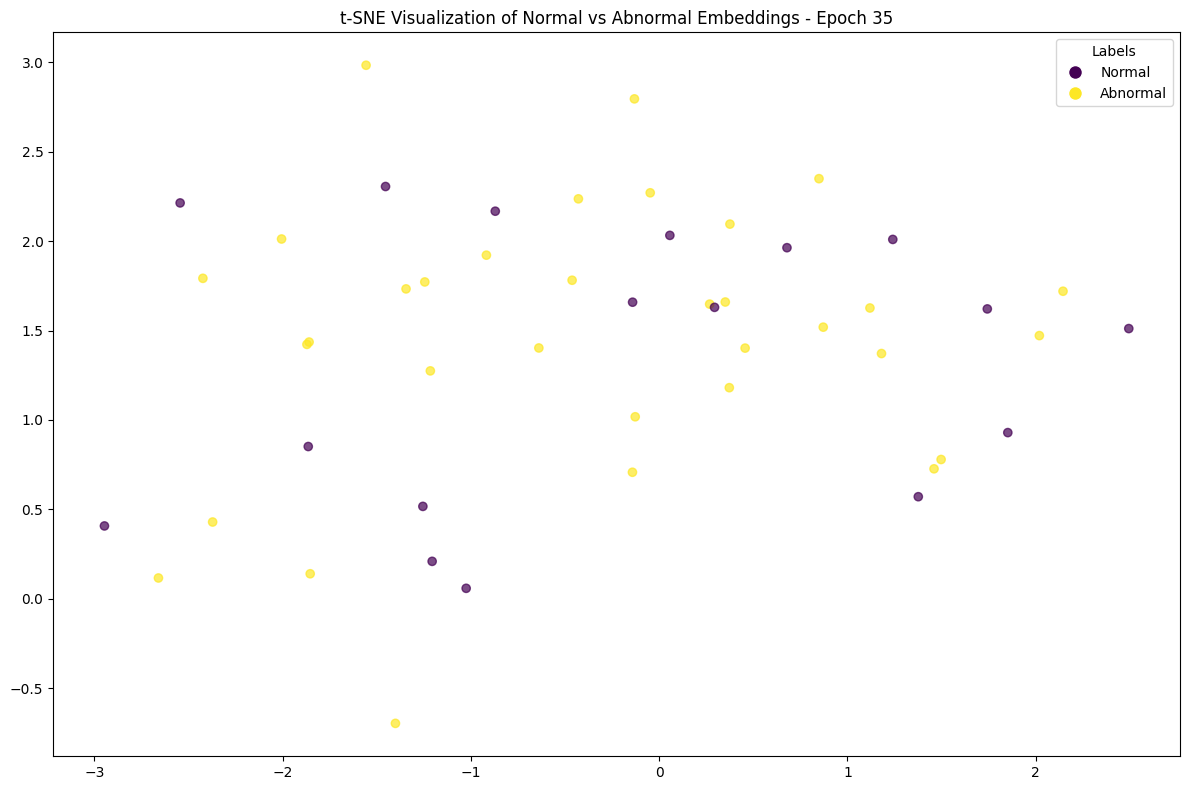

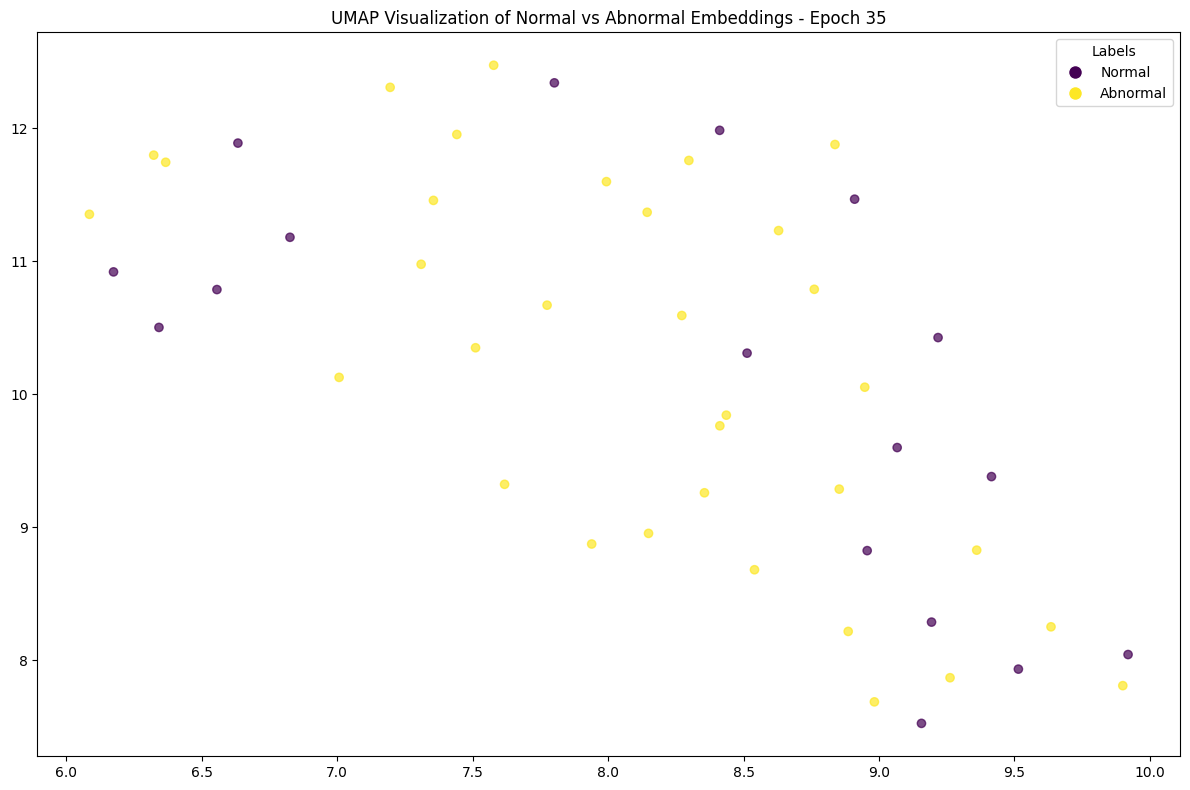

In [65]:
plot_tsne_and_umap(list(filename_to_embeddings.values()), list(filename_to_labels.values()), epoch)

In [60]:
len(list(filename_to_embeddings.values()))

10

In [ ]:
# class token
# linresr probing
# evaluating embeddinfgs in transfoemers
# recobnstruction in other transformers